In [10]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [20]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
# Packages for data preparation
from sklearn.model_selection import train_test_split
#from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence
root = Path('../')
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history
def eval_metric(model, history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    e = range(1, NB_START_EPOCHS + 1)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results
    
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):

    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [11]:
df = uploaded;

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 10254 to 7472
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               14640 non-null  object
 1   airline_sentiment  14640 non-null  object
dtypes: object(2)
memory usage: 343.1+ KB


In [17]:
df = df.reindex(np.random.permutation(df.index))  # shuffle the data
df = df[['text', 'airline_sentiment']]

In [18]:
df

,text,airline_sentiment
10254,@USAirways checked into my flight yesterday an...,negative
1045,@united it's like you're trying to make me hat...,negative
3186,@united recent services have been very bad. My...,negative
9115,@USAirways knows customer service!! Thank you ...,positive
8478,@Jetblue Delay = Perfect time to learn Swift p...,negative
...,...,...
12022,@americanair I sure do. I'm running version 3....,neutral
7831,@JetBlue Kudos to JetBlue social media team fo...,positive
5440,@SouthwestAir how often are airplane seats/tra...,negative
9560,@USAirways @AmericanAir I need to move a reser...,neutral


In [21]:
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

In [22]:
df.text

10254     checked flight yesterday bumped Tuesday fligh...
1045      like trying make hate airline. Fee checked ba...
3186      recent services bad. My NC trip aweful. Very ...
9115      knows customer service!! Thank starting week ...
8478           Delay Perfect time learn Swift programming 
                               ...                        
12022                  sure do. I'm running version 3.10.0
7831      Kudos JetBlue social media team jumping helpi...
5440      often airplane seats/tray tables cleaned sani...
9560       need move reservation due weather middle par...
7472      blaming  flight 584 luggage debacle! #luggage...
Name: text, Length: 14640, dtype: object

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.3, random_state=37)

In [26]:
##Converting words into numbers
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [27]:
##Converting target class to numbers
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [28]:
##Splitting validation set
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.3, random_state=37)

Minimum validation loss reached in epoch 6


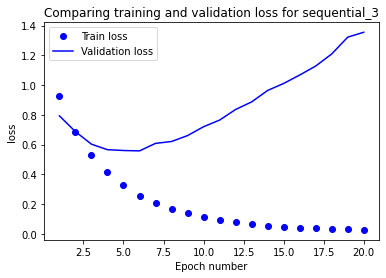

In [32]:
##Creating Overfitting Model
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))

base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

Minimum validation loss reached in epoch 20


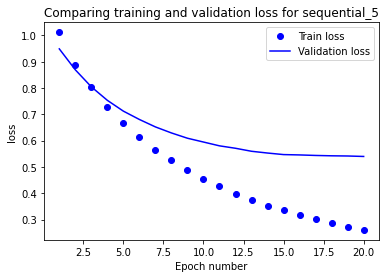

In [34]:
## Lowering number of networks
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

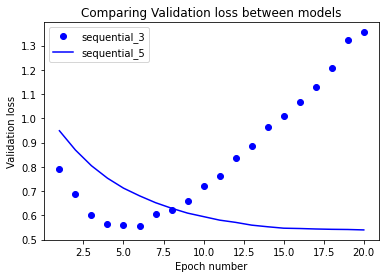

In [35]:
##Comparing the two models
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

In [37]:
## L2 Regularization
reg_model = models.Sequential()
##Adding smaller weights
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 6


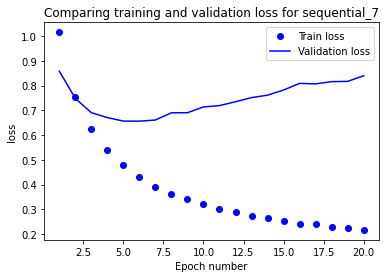

In [38]:
eval_metric(reg_model, reg_history, 'loss')

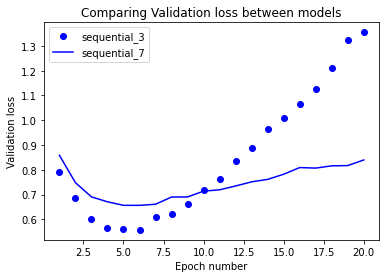

In [39]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

Minimum validation loss reached in epoch 7


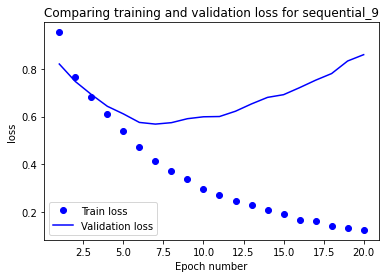

In [41]:
## Adding a dropout layer
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

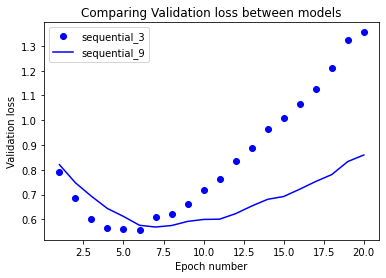

In [42]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

In [43]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

138/138 [==============================] - 0s 3ms/step - loss: 0.9655 - accuracy: 0.7543

Test accuracy: 75.43%
138/138 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.7816

Test accuracy: 78.16%
138/138 [==============================] - 0s 3ms/step - loss: 0.8149 - accuracy: 0.7573

Test accuracy: 75.73%
138/138 [==============================] - 0s 3ms/step - loss: 0.7578 - accuracy: 0.7801

Test accuracy: 78.01%


In [44]:
print("done")

done
